<a href="https://colab.research.google.com/github/ammusin/Respiratory_disease_detection/blob/main/MobileNet%2BEfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkarmanohardalvi/lungs-disease-dataset-4-types")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lungs-disease-dataset-4-types


In [ ]:
import os

base_path = '/kaggle/input/lungs-disease-dataset-4-types'
print(os.listdir(base_path))


['Lung Disease Dataset']


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Data Augmentation
train_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255
)
val_gen = ImageDataGenerator(rescale=1/255)
test_gen = ImageDataGenerator(rescale=1/255)

# 2. Data Loading
train_data = train_gen.flow_from_directory(
    os.path.join(base_path, 'Lung Disease Dataset', 'train'),
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=128,
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    os.path.join(base_path, 'Lung Disease Dataset', 'val'),
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=128,
    shuffle=True
)

test_data = test_gen.flow_from_directory(
    os.path.join(base_path, 'Lung Disease Dataset', 'test'),
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=128,
    shuffle=False
)

# 3. Model Building (Hybrid MobileNetV2 + EfficientNetB0)

input_layer = Input(shape=(128, 128, 3))

# Load MobileNetV2
mobile_net = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)
mobile_output = GlobalAveragePooling2D()(mobile_net.output)

# Load EfficientNetB0
efficient_net = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)
efficient_output = GlobalAveragePooling2D()(efficient_net.output)

# Concatenate outputs
merged = Concatenate()([mobile_output, efficient_output])

# Add dense layers
x = Dense(256, activation='relu')(merged)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(5, activation='softmax')(x)

# Final model
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

# 4. Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Early Stopping
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

# 6. Train
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    callbacks=[early_stopping]
)


Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


<ipython-input-4-692157667778>:56: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_net = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 6,996,712 (26.69 MB)

 Trainable params: 6,920,577 (26.40 MB)

 Non-trainable params: 76,135 (297.41 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - accuracy: 0.4020 - loss: 1.3977 - val_accuracy: 0.3715 - val_loss: 1.5787
Epoch 2/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7269 - loss: 0.6779 - val_accuracy: 0.3537 - val_loss: 2.0911
Epoch 3/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7720 - loss: 0.5574 - val_accuracy: 0.3884 - val_loss: 2.1982
Epoch 4/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7988 - loss: 0.4880 - val_accuracy: 0.5069 - val_loss: 1.6340
Epoch 5/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8239 - loss: 0.4411 - val_accuracy: 0.3596 - val_loss: 2.9444
Epoch 6/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8278 - loss: 0.4215 - val_accuracy: 0.3695 - val_loss: 2.6595
Epoch 7/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8298 - loss: 0.4010 - val_accuracy: 0.3571 - val_loss: 2.7630
Epoch 8/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8291 - loss: 0.4008 - val_accuracy: 0.3130 - val_los

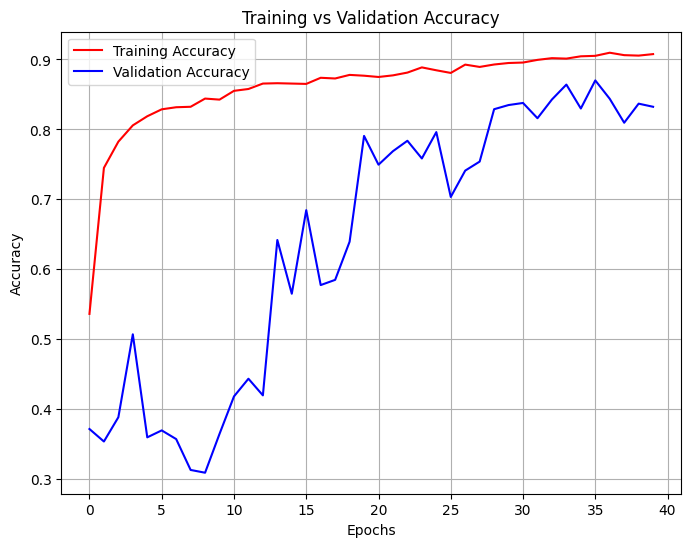

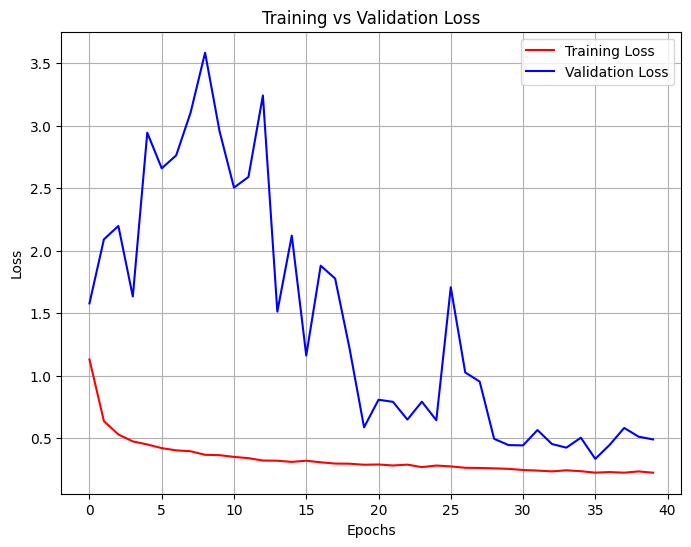

In [ ]:
# Accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy", color='r')
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color='b')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss graph
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Training Loss", color='r')
plt.plot(history.history["val_loss"], label="Validation Loss", color='b')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted Class: Normal


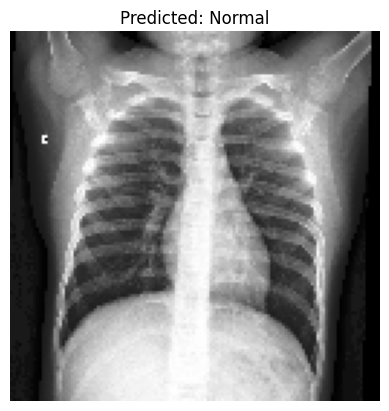

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 1. Load your image
img_path = '/content/Normal.jpeg'  # 🔥 Change to your test image path
img = image.load_img(img_path, target_size=(128, 128), color_mode="rgb")

# 2. Convert to array
img_array = image.img_to_array(img)

# 3. Normalize
img_array = img_array / 255.0

# 4. Expand dimensions (batch format)
img_array = np.expand_dims(img_array, axis=0)

# 5. Predict
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

# 6. Map the prediction back to class name
class_labels = list(test_data.class_indices.keys())
print(f"Predicted Class: {class_labels[predicted_class[0]]}")

# 7. Visualize the image
plt.imshow(img_array[0])
plt.title(f"Predicted: {class_labels[predicted_class[0]]}")
plt.axis('off')
plt.show()
